<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import lightgbm as lgbm
from sklearn.model_selection import TimeSeriesSplit #

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv',  index_col=[0], parse_dates=[0])
except:
    print('Что-то пошло не так')

## Анализ

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
print(df.index.is_monotonic)

True


Временной ряд индекса монотонный. Что и требовалось.

Посмотрим на график зависимости количества заказов от времени. Так как данные представлены с интервалом 10 мин - ресеплируем их на интервал 1 час.

<AxesSubplot:xlabel='datetime'>

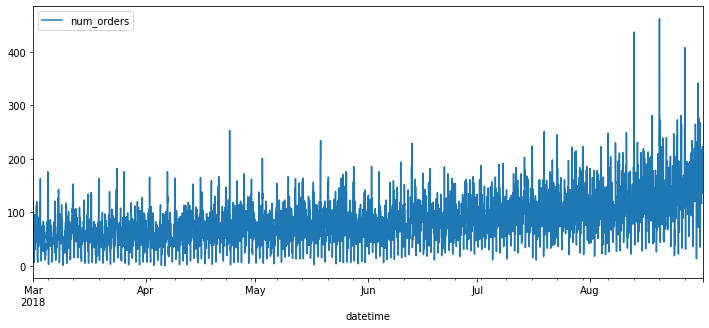

In [6]:
df = df.resample('1H').sum()

figsize = (12,5)
df.plot(figsize=figsize)


Из графика можно сделать вывод, что временной ряд нестационарен, меняется как дисперсия, так и среднее значение.

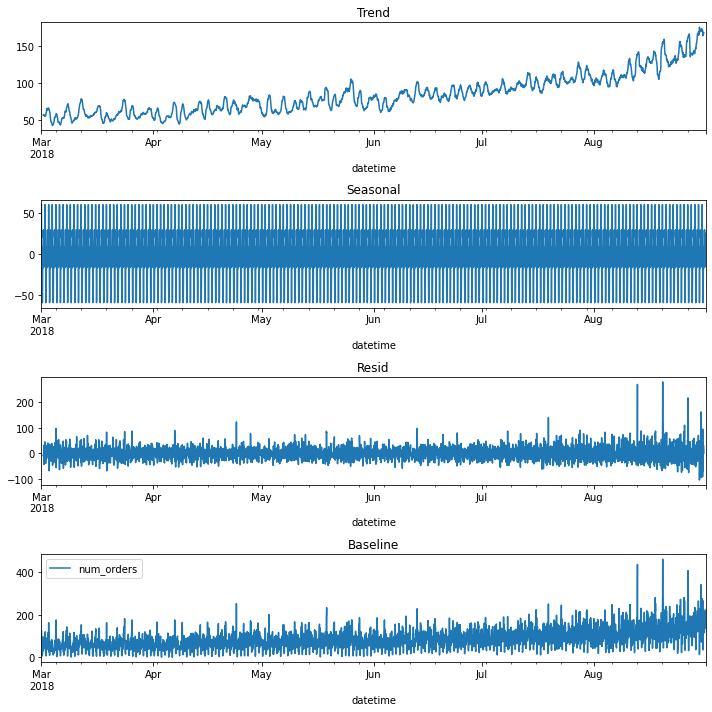

In [7]:
figsize = (10,10)
sd_df = seasonal_decompose(df)

plt.figure(figsize=figsize)

plt.subplot(411)
sd_df.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(412)
sd_df.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(413)
sd_df.resid.plot(ax=plt.gca())
plt.title('Resid')

plt.subplot(414)
df.plot(ax=plt.gca())
plt.title('Baseline')

plt.tight_layout()


По тренду видно, что количество заказов возрастает. Ну и логично, что шум со временем возрастает, так как увеличивается количество заказов, дисперсия.

In [8]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


Уменьшим интервал, возьмем отрезок в одну неделю от пон. до вс: '2018-08-20':'2018-08-26'

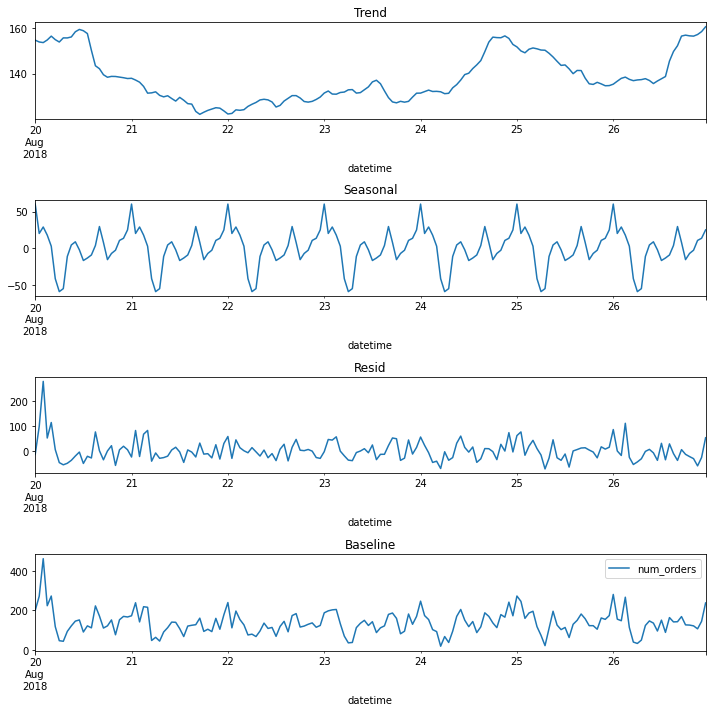

In [9]:
figsize = (10,10)
sd_df = seasonal_decompose(df)

plt.figure(figsize=figsize)

plt.subplot(411)
sd_df.trend['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(412)
sd_df.seasonal['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(413)
sd_df.resid['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.title('Resid')

plt.subplot(414)
df['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.title('Baseline')

plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

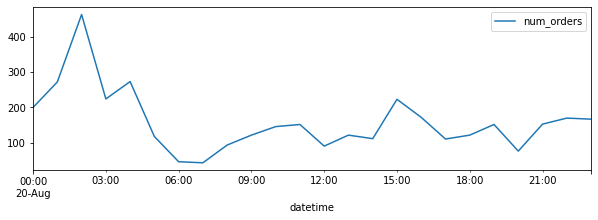

In [10]:
# посмотрим количество заказов за день
df['2018-08-20':'2018-08-20'].plot(figsize=(10,3))

Видим изменение количество заказов в течении недели, можно увидеть и закономерности изменений в течении дня. Пики в вечерне-ночное время, середине дня.

## Обучение

Создадим новые фичи:

In [11]:
def make_features(df, max_lag, rolling_mean_size):
  
    #df['Year']=df.index.year
    #df['Month']=df.index.month
    df['Day']=df.index.day
    df['Day_of_week']=df.index.dayofweek
    
    for i in range(1, max_lag + 1):
        df['lag_{}'.format(i)] = df['num_orders'].shift(i)
    df['rolling_mean'] = df['num_orders'].shift().rolling(window=rolling_mean_size).mean()
    return df
    

In [12]:
df_exp = df.copy()
df_exp = make_features(df_exp, 25, 25)

In [13]:
df_exp.sample(2)

,num_orders,Day,Day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-04-16 15:00:00,71,16,0,58.0,74.0,52.0,81.0,138.0,72.0,69.0,...,104.0,94.0,66.0,97.0,56.0,38.0,92.0,64.0,46.0,74.12
2018-05-19 11:00:00,94,19,5,48.0,77.0,84.0,18.0,15.0,24.0,89.0,...,60.0,84.0,120.0,55.0,87.0,85.0,49.0,102.0,102.0,92.00


In [14]:
df_exp.columns

Index(['num_orders', 'Day', 'Day_of_week', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25',
       'rolling_mean'],
      dtype='object')

In [15]:
#Укажем категориальные данные
#cat_cols = ['Year', 'Month', 'Day', 'Day_of_week']
cat_cols = ['Day_of_week']

In [16]:
df_exp = df_exp.dropna()
X = df_exp.drop(columns=['num_orders'])
y = df_exp['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123, shuffle=False)

In [17]:
# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

<b> CatBoost

In [18]:
%%time
# catboost

catboost_model = CatBoostRegressor(loss_function='RMSE', cat_features=cat_cols)

params = {'depth': [5, 10, 20, 40],
          'learning_rate' : [0.3,  0.5, 0.7, 2],
         #'l2_leaf_reg': [5, 10],
         'iterations': [400]}


catboost_grid = catboost_model.grid_search(param_grid = params, X=X_train, y=y_train, cv=tscv, plot=True)
# поправил cv

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 59.8232900	test: 93.4515778	best: 93.4515778 (0)	total: 53.2ms	remaining: 21.2s
1:	learn: 46.4670731	test: 78.8912155	best: 78.8912155 (1)	total: 58.4ms	remaining: 11.6s
2:	learn: 37.3737960	test: 66.6997890	best: 66.6997890 (2)	total: 63.4ms	remaining: 8.39s
3:	learn: 31.7493818	test: 58.1815961	best: 58.1815961 (3)	total: 68.5ms	remaining: 6.78s
4:	learn: 28.0532596	test: 51.7999137	best: 51.7999137 (4)	total: 73.6ms	remaining: 5.81s
5:	learn: 26.0550130	test: 47.4061586	best: 47.4061586 (5)	total: 78.1ms	remaining: 5.13s
6:	learn: 24.8109400	test: 44.6581911	best: 44.6581911 (6)	total: 83ms	remaining: 4.66s
7:	learn: 24.1116125	test: 42.9670663	best: 42.9670663 (7)	total: 89.3ms	remaining: 4.38s
8:	learn: 23.4864300	test: 41.1260174	best: 41.1260174 (8)	total: 96.2ms	remaining: 4.18s
9:	learn: 23.0514155	test: 40.2457706	best: 40.2457706 (9)	total: 103ms	remaining: 4.02s
10:	learn: 22.6151202	test: 39.6245674	best: 39.6245674 (10)	total: 108ms	remaining: 3.82s
11:	learn: 2

learning rate is greater than 1. You probably need to decrease learning rate.


10:	learn: 61.2109815	test: 72.7018872	best: 69.9981579 (0)	total: 50.4ms	remaining: 1.78s
11:	learn: 60.0400826	test: 86.7944509	best: 69.9981579 (0)	total: 54.5ms	remaining: 1.76s
12:	learn: 58.5085657	test: 67.8880183	best: 67.8880183 (12)	total: 59.1ms	remaining: 1.76s
13:	learn: 57.0160947	test: 83.1867117	best: 67.8880183 (12)	total: 63.6ms	remaining: 1.75s
14:	learn: 55.5018979	test: 65.3622437	best: 65.3622437 (14)	total: 68ms	remaining: 1.74s
15:	learn: 54.1717387	test: 82.1877159	best: 65.3622437 (14)	total: 72.3ms	remaining: 1.73s
16:	learn: 52.7731009	test: 67.9806750	best: 65.3622437 (14)	total: 76.6ms	remaining: 1.73s
17:	learn: 51.2568183	test: 78.9299892	best: 65.3622437 (14)	total: 80.7ms	remaining: 1.71s
18:	learn: 50.1941540	test: 65.7364835	best: 65.3622437 (14)	total: 91ms	remaining: 1.82s
19:	learn: 49.1972623	test: 77.9337472	best: 65.3622437 (14)	total: 95.4ms	remaining: 1.81s
20:	learn: 48.2551759	test: 64.3919029	best: 64.3919029 (20)	total: 100ms	remaining: 1

learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 74.7034079	test: 70.9221146	best: 70.9221146 (0)	total: 69ms	remaining: 27.5s
1:	learn: 68.7135156	test: 111.2626668	best: 70.9221146 (0)	total: 137ms	remaining: 27.2s
2:	learn: 65.4483793	test: 82.0419296	best: 70.9221146 (0)	total: 191ms	remaining: 25.2s
3:	learn: 64.9000428	test: 115.0546863	best: 70.9221146 (0)	total: 195ms	remaining: 19.3s
4:	learn: 60.9049385	test: 86.8313440	best: 70.9221146 (0)	total: 248ms	remaining: 19.6s
5:	learn: 57.5827953	test: 103.8073148	best: 70.9221146 (0)	total: 312ms	remaining: 20.5s
6:	learn: 54.5664653	test: 89.1986854	best: 70.9221146 (0)	total: 366ms	remaining: 20.5s
7:	learn: 48.4999891	test: 101.3287188	best: 70.9221146 (0)	total: 421ms	remaining: 20.6s
8:	learn: 46.2456086	test: 90.1448255	best: 70.9221146 (0)	total: 476ms	remaining: 20.7s
9:	learn: 43.7944136	test: 97.8532126	best: 70.9221146 (0)	total: 532ms	remaining: 20.7s
10:	learn: 41.0936108	test: 91.4289442	best: 70.9221146 (0)	total: 588ms	remaining: 20.8s
11:	learn: 38.800

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


Estimating final quality...
Training on fold [0/3]
0:	learn: 48.6875203	test: 61.6099618	best: 61.6099618 (0)	total: 3.91ms	remaining: 1.56s
1:	learn: 38.8238587	test: 50.7550107	best: 50.7550107 (1)	total: 7.02ms	remaining: 1.4s
2:	learn: 31.8651887	test: 43.5031668	best: 43.5031668 (2)	total: 10.2ms	remaining: 1.35s
3:	learn: 27.3621320	test: 37.8281680	best: 37.8281680 (3)	total: 13.9ms	remaining: 1.37s
4:	learn: 24.1008016	test: 33.9635640	best: 33.9635640 (4)	total: 16.8ms	remaining: 1.32s
5:	learn: 22.2331453	test: 31.1559213	best: 31.1559213 (5)	total: 19.7ms	remaining: 1.29s
6:	learn: 21.1270602	test: 29.5770839	best: 29.5770839 (6)	total: 22.5ms	remaining: 1.26s
7:	learn: 20.1995688	test: 28.5184161	best: 28.5184161 (7)	total: 25.5ms	remaining: 1.25s
8:	learn: 19.5320091	test: 27.8735391	best: 27.8735391 (8)	total: 28.3ms	remaining: 1.23s
9:	learn: 18.9858380	test: 27.1183527	best: 27.1183527 (9)	total: 31.2ms	remaining: 1.22s
10:	learn: 18.5169376	test: 26.5768317	best: 26.57

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=False)
# train,test = train_test_split(final_frame,shuffle = False, random_state = 42, test_size = 0.1)
# valid,test = train_test_split(test,shuffle = False, random_state = 42, test_size = 0.5)

In [20]:
#LGMBoost
lgbm_model = lgbm.LGBMRegressor(metric = 'l2',
                                max_depth=10,
                                n_estimators=100,
                                learning_rate=0.1,
                                objective='mse',
                                n_jobs=-1, random_state=0)

In [21]:
%%time
lgbm_model.fit(X_train, y_train)

CPU times: user 1.36 s, sys: 7.84 ms, total: 1.37 s
Wall time: 1.34 s


LGBMRegressor(max_depth=10, metric='l2', objective='mse', random_state=0)

In [22]:
# params = {'metric': 'l2', 'max_depth':10,"random_state": 42, "learning_rate":0.1, 'objective':'mse'}
# lgbm_ds = lgbm.Dataset(X_train, y_train)
# model = lgbm.cv(params=params, train_set=lgbm_ds)

# у MS всегда все не как у людей, API отличается от привычного. 
# Кросс-валидацию не смог реализовать на LGMBoost. Документацию читал, но как сделать предикт после cv - не понял.
# Так как конечная цель все таки получить rmse моделей на тестовой выборке, оставляю код без изменений.

In [23]:
#RandomForest
param_grid = { 
    'n_estimators': [10, 15, 23],
    'max_depth': [5, 8, 10, 15]
}

gs_rf_regr = GridSearchCV(RandomForestRegressor(), param_grid, cv=tscv, n_jobs=-1) #поправил cv

In [24]:
%%time
gs_rf_regr.fit(X_train, y_train)

CPU times: user 10.9 s, sys: 48 ms, total: 11 s
Wall time: 11 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 10, 15],
                         'n_estimators': [10, 15, 23]})

In [25]:
# %%time
# lr_regr = LinearRegression()
# lr_regr.fit(X_train, y_train)

In [27]:
%%time
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
gs_lr_regr = GridSearchCV(model,parameters, cv=tscv)

gs_lr_regr.fit(X_train, y_train)

CPU times: user 1.57 s, sys: 2.87 s, total: 4.44 s
Wall time: 4.51 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]})

## Тестирование

In [28]:
#catboost
mse(y_test, catboost_model.predict(X_test), squared=False)

44.87278595563594

In [29]:
#lightbgm
mse(y_test, lgbm_model.predict(X_test), squared=False)

41.85243525543002

In [30]:
#RandomForest
mse(y_test, gs_rf_regr.predict(X_test), squared=False)

45.41171987848674

In [31]:
#linear regression
mse(y_test, gs_lr_regr.predict(X_test), squared=False)

44.98100352501847

<b>Вывод:
в результате подбора гиперпараметров модели и параметров фукции make_features удалось достичь требуемой точности на всех моделях. При этом лучшие показатели у модели LightBGM с  отличной скоростью обучения,  линейная регрессия заняла второе место по точности и скорости обучения.
    